# Component Separation

### Tom Crawford

In this exercise we use the known or expected behavior of signal and noise components in maps to extract (in as close to an optimal way as possible) a map of one of those signal components (or independent maps of multiple components).

## Background

In CMB experiments, we observe the sky in multiple (fairly wide) frequency bands. Why? Why not just concentrate on the best possible band? Because there are other signals in the sky besides the CMB. The process of teasing these signals apart from one another is generally called <i>component separation</i>. 

For the purposes of this notebook, let's consider two signals: 

1. The CMB, or, specifically, the primary CMB temperature anisotropy.
2. The thermal Sunyaev-Zel'dovich, or tSZ effect.

How do we tell these two signals apart? By their different dependence on observing frequency. The tSZ effect causes a slight distortion in the CMB spectrum. That effect is negative in some observing bands, and positive in others, and we can use that to separate it from the primary CMB. Here's a plot of that from Carlstrom, Holder, and Reese (2002). The dashed line is the undistorted CMB spectrum, while the solid line is the tSZ spectrum.

<div>
<img src="compsep_fig1.png" width="500">
</div>

## Math

Let's assume we are starting with some number of maps in different frequency bands that contain primary CMB, tSZ, and noise. The goal is an optimal (in the signal-to-noise sense) map that contains only the signal we want---or multiple maps, each independent of one another, and each containing only one signal. There are many ways to derive the operation that yields this goal, but I like to think of this as yet another instance of the linear least-squares (LLS) problem that comes up all the time in CMB stuff. Our model of the information in the map from one of the frequency bands is

$$m_i = \sum_j a_{ij} \ s_j + n_i,$$

where $a_{ij}$ encodes the frequency dependence (or spectral energy distribution, or SED) of signal $s_j$, and $n_i$ is the noise in map $m_i$. We want to construct the minimum-variance estimate of signals $s_j$. I won't derive it here, but anyone familiar with LLS will intuit that the solution is of the form

$$\bar{s} = (a^T W a)^{-1} a^T W m,$$

where $W$ is a weight matrix. The minimum-variance solution will be when the weight matrix is the inverse of the noise covariance:

$$W = \langle n n^T \rangle^{-1} \equiv C^{-1}.$$

You can think of the entire $(a^T W a)^{-1} a^T W$ part as a set of "band weights" $w_{ij}$ multiplying the individual maps, so that 

$$\bar{s_j} = \sum_i w_{ij} m_i.$$

An added bonus (again familiar to LLS devotees) is that $(a^T W a)^{-1}$ is the parameter covariance matrix, i.e. the predicted (squared) uncertainty in the parameters you are constraining with the LLS. In this case, the parameters are the pixel values in the component maps, so the diagonal elements of $(a^T W a)^{-1}$ are the predicted variance in the component maps.

## Implementation

To build $w_{ij}$, we need two things: The SED for the component(s) we want to extract, and the band-band covariance matrix $C$. The SED part is easy. Most CMB experiments calibrate their data such that the maps are in units of equivalent CMB fluctuation temperature. That means the SED of the primary CMB is equal to 1 everywhere. The SED of the tSZ relative to the primary CMB (at least to first order) is a relatively simple function of frequency (see, e.g., Carlstrom+02 Equation 2).

The covariance matrix is trickier. In general, it is an $N_\mathrm{bands} \times N_\mathrm{pixel}$-by-$N_\mathrm{bands} \times N_\mathrm{pixel}$ matrix, and high-resolution CMB maps have millions of pixels, which makes writing down and inverting this really hard. To do 
For the example here, where the noise is uncorrelated between pixels (white) and statistically uniform across the maps (no part of the map has higher noise than any other), we can collapse this down to a single diagonal $N_\mathrm{bands}$-by-$N_\mathrm{bands}$ matrix, and the problem is much easier. In more realistic cases, the noise is not uncorrelated between pixels. But if the statistical properties of the noise don't vary across the map, the covariance matrix will only depend on the distance between pixels, which magically makes the matrix diagonal in Fourier space. The noise is not the same at every Fourier mode, so we have calculate the band weights separately at every Fourier mode, but at least the calculation is independent between modes. This is why component separation is usually performed in Fourier space.

In this exercise, we will create simulated maps at each of three typical CMB experiment frequency bands (centered at 95, 150, and 220 GHz), calculate the proper set of band weights to separate the CMB and tSZ signals, apply these to the individual frequency maps, and compare the result to the input component maps.


## First we read in the necessary libraries.

In [7]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

%matplotlib inline
import constants as cs # the constants module

from cmb_modules import * # the module of functions

N = cs.N
N_iterations = cs.N_iterations
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = 0#cs.atmospheric_noise_level
one_over_f_noise_level = 0#cs.one_over_f_noise_level

### rebuildng simulated signal maps from previous excercises

In [11]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

N=int(N)

## make an SZ map
SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)



### making individual frequency maps, including noise

Note the implementation of the tSZ spectral behavior from, e.g., Carlstrom+02.

For noise, arbitrarily assume 95 GHz is 1.5 times as noisy as 150 GHz, and 220 GHz is 3 times as noisy as 150 GHz. (This is actually not far from what real CMB experiments often achieve.)

('map mean:', -13.56699190344178, 'map rms:', 110.34900490811079)


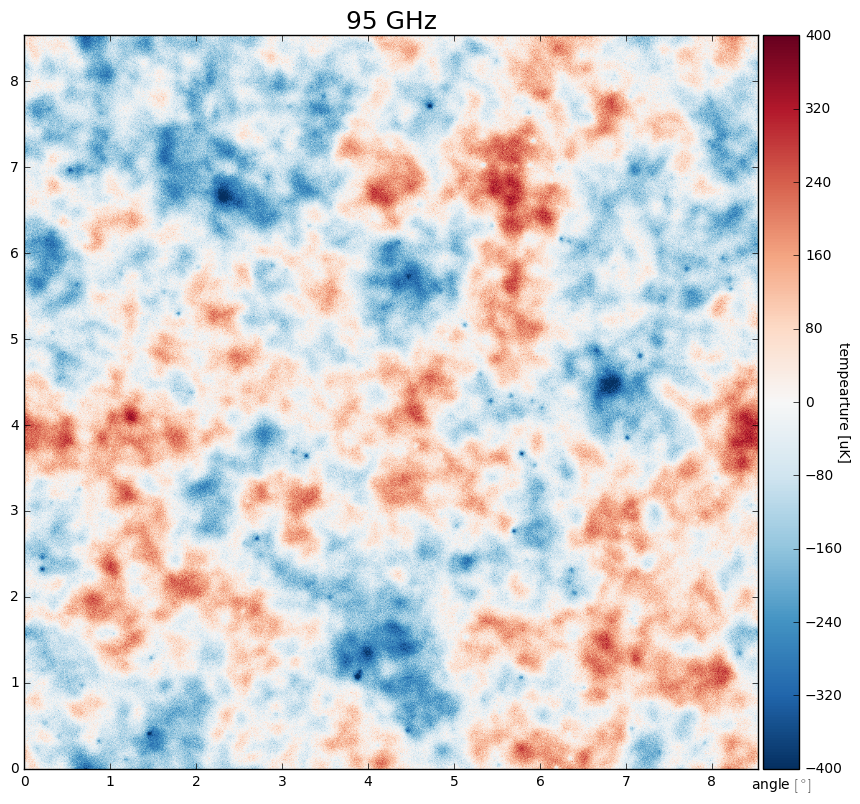

('map mean:', -4.7811577708014177, 'map rms:', 107.54155686295844)


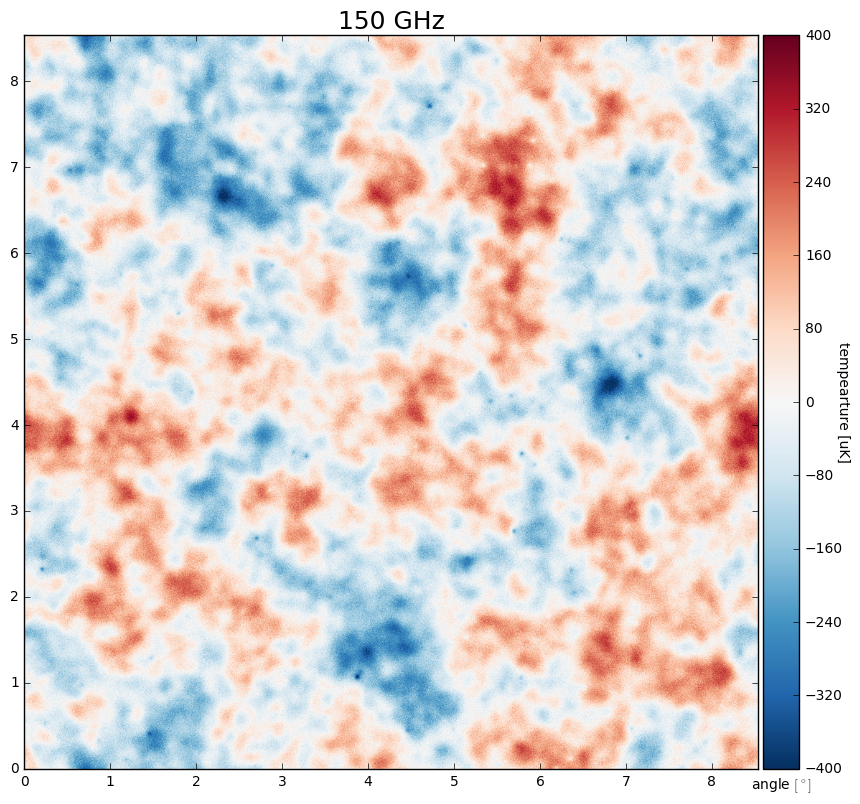

('map mean:', 9.6867776164448784, 'map rms:', 121.17974300140139)


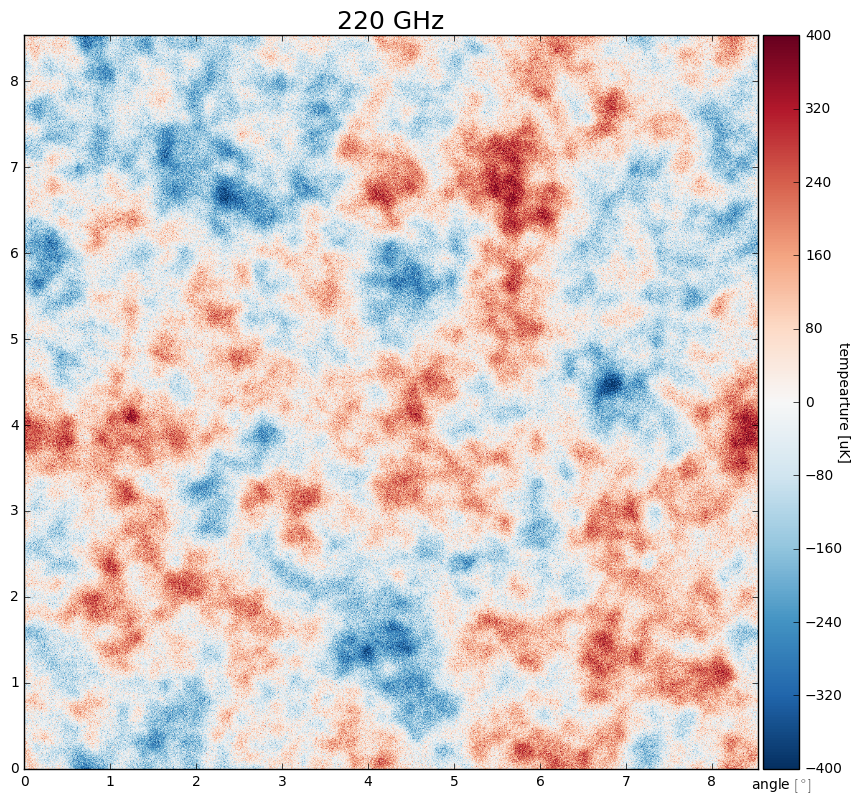

In [32]:
bands =  np.array([95.,150.,220.])
nb = len(bands)
xb = bands/56.7 # h nu / kT
szfac = xb * (np.exp(xb)+1.)/(np.exp(xb)-1.) - 4. # tSZ spectral dependence
szfac_norm = szfac / szfac[1] # the original SZMap was made for 150 GHz
# arbitrarily assume 95 GHz is 1.5 times as noisy as 150 GHz, and 220 GHz is 3 times as noisy as 150 GHz.
white_noise_levels = np.array([white_noise_level*1.5,white_noise_level,white_noise_level*3.])

maps = np.zeros([nb,cs.N,cs.N])
for i in np.arange(nb):
# for now assume all bands have same beam
    this_total_map = CMB_T + SZMap*szfac_norm[i]
    this_total_map = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,this_total_map)
# add white noise
    thisNoise = make_noise_map(N,pix_size,white_noise_levels[i],atmospheric_noise_level,one_over_f_noise_level) 
    maps[i,:,:] = this_total_map + thisNoise
# plot the result
    plt.title(str(np.int(bands[i]))+' GHz',fontsize=18)
    p=Plot_CMB_Map(maps[i,:,:],c_min,c_max,X_width,Y_width)#,Title=str(bands[i])+' GHz')


### Look at the maps ###

How are they similar? How are they different? In particular, can you see obvious tSZ signal from galaxy clusters in all three maps? If not, why? (Hint, look at the value of the szfac_norm variable.)

### Constructing the band weights

#### EXERCISE: 

Fill out the skeleton of the band_weights function below, create an array of SEDs to hand it, run the function to get band weights, and apply those band weights to the single-frequency maps to get component maps.

For this exercise, you will need to figure out how to:

1. Make an N_band-by-N_band covariance matrix that encodes the noise levels in each map.
2. Create an array that encodes the SEDs of the primary CMB anisotropy and the tSZ.
3. Do the linear algebra on those arrays/matrices to get the band weights.
4. Apply the band weights to the frequency maps to get a CMB-free tSZ map and a tSZ-free CMB map.

OK, first define the band weights function and get the band weights.

In [76]:
#def band_weights(seds,white_noise_levels):
    ## seds: the SED or frequency dependence of the signals we want to extract. Should have shape N_signals-by-N_bands.
    ## white_noise_levels: the white noise levels in each band's map.

    # here we translate white noise levels into a covariance matrix
    
    # here we invert the covariance matrix
    
    # here we multiply the covariance on both sides by the SEDs to create (a^T W a)
    
    # now we invert (a^T W a) to get (a^T W a)^{-1}
    
    # now we multiply that onto a^T W again to get the full band weights
    
#    bweights = np.zeros([2,3])
    
#    return(bweights)

def band_weights(seds,white_noise_levels,return_noise_pred=False):
    ## seds: the SED or frequency dependence of the signals we want to extract. Should have shape N_signals-by-N_bands.
    ## white_noise_levels: the white noise levels in each band's map.

    # here we translate white noise levels into a covariance matrix
    sedshape = np.shape(seds)
    if len(sedshape) > 1:
        nb = sedshape[0]
        nsed = sedshape[1]
    else:
        nb = sedshape
        nsed = 1
    covmat = np.zeros([nb,nb])
    for i in np.arange(nb):
        covmat[i,i] = white_noise_levels[i]**2
    
    # here we invert the covariance matrix
    wmat = np.linalg.inv(covmat)
    
    # here we multiply the covariance on both sides by the SEDs to create (a^T W a)
    atw = np.dot(np.transpose(seds),wmat)
    atwa = np.dot(atw,seds)
    
    # now we invert (a^T W a) to get (a^T W a)^{-1}
    iatwa = np.linalg.inv(atwa)
    if nsed > 1:
        noise_pred = np.asarray([np.sqrt(iatwa[i,i]) for i in np.arange(nsed)])
    else:
        noise_pred = np.sqrt(iatwa)
    
    # now we multiply that onto a^T W again to get the full band weights
    bweights = np.dot(iatwa,atw)
    
    if return_noise_pred:
        return bweights, noise_pred
    else:
        return bweights

#my_seds = [] # what do we use for input SEDs, and how do we code that up?
my_seds = np.zeros([nb,2])
my_seds[:,0] = 1.
my_seds[:,1] = szfac_norm
bweights, noise_pred = band_weights(my_seds,white_noise_levels,return_noise_pred=True)
print(bweights)
print(noise_pred)

[[-0.63234102  1.05947624  0.57286478]
 [ 0.82978147 -0.37655989 -0.45322158]]
[ 22.30634571  18.81407574]


### Look at the band weights.

Think about why the algorithm "chooses" to use these particular proportions of each band's information.

Now we just multiply each individual frequency map by the band weights to get our component maps. This should be doable with one matrix operation, but np.dot assumes very weird things about matrix shapes, so I would do it one at a time (but maybe you will find a better way!).

('map mean:', 9.0626562692387882, 'map rms:', 114.31227109755974)


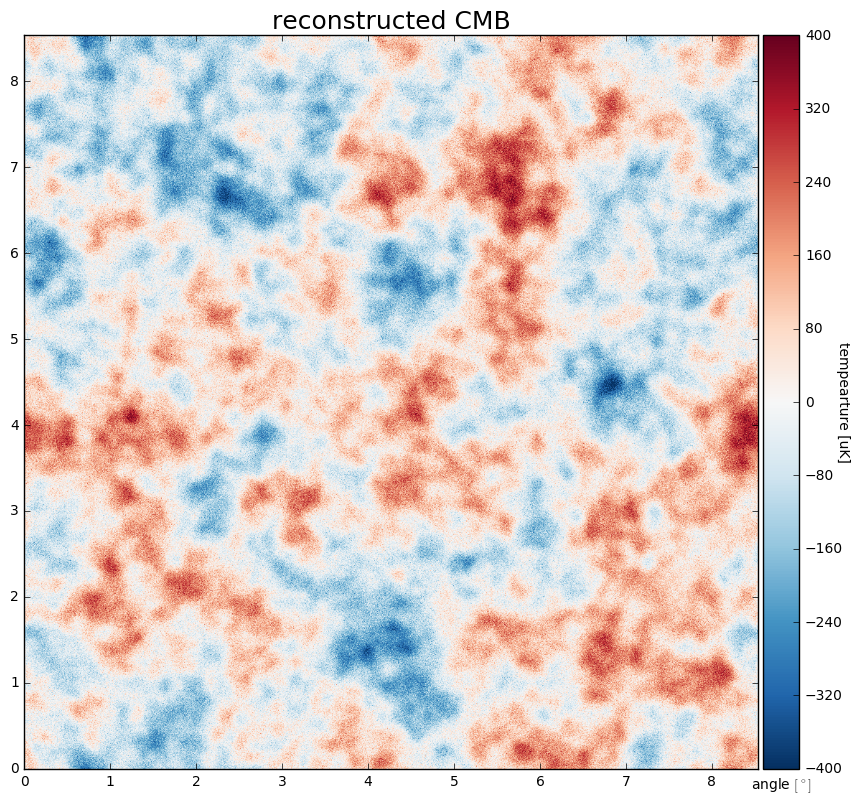

('map mean:', -13.847502909910714, 'map rms:', 38.251009588163576)


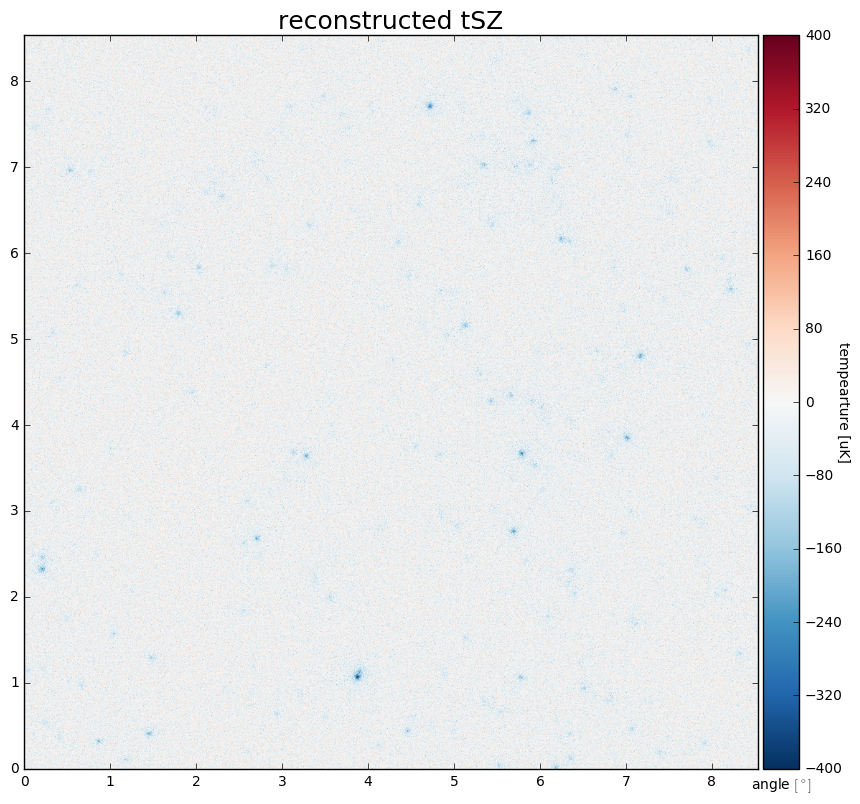

In [63]:
component_maps = np.zeros([2,N,N])
for i in np.arange(2):
    for j in np.arange(nb):
        component_maps[i,:,:] += bweights[i,j]*maps[j,:,:]
#np.dot(bweights,np.reshape(maps,[1024,3,1024]))
# plot the result
compnames = ['CMB','tSZ']
for i in np.arange(2):
    plt.title('reconstructed ' + compnames[i],fontsize=18)
    p=Plot_CMB_Map(component_maps[i,:,:],c_min,c_max,X_width,Y_width)#,Title=str(bands[i])+' GHz')


### Do these look right?

Compare to the original component maps. Do the reconstructed maps resemble the inputs?

#### Advanced exercise

Calculate the bias and residual noise of the reconstructed component maps. By "bias" here, we mean any deviation of the amplitude of the signal in the reconstructed map from the true signal amplitude. 

We also want to know how noisy our reconstructed maps are. An ancillary output of the band_weights calculation is the predicted noise in the component maps. Try subtracting the true signal from the reconstructed maps, calculating the standard deviation of the result, and comparing it to the predicted noise (you will have to add a piece to the band_weights code to return the predicted noise. 

##### Warning

If the rms of the residual maps doesn't quite match the prediction, try multiplying the rms by the pixel size in arcminutes. (Why? What units are the white_noise_levels in?)


In [80]:
this_total_map = CMB_T + SZMap*szfac_norm[i]
SZMap_beam = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,SZMap)
CMB_T_beam = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,CMB_T)
SZampl = np.sum(component_maps[1,:,:]*SZMap_beam)/np.sum(SZMap_beam**2)
CMBampl = np.sum(component_maps[0,:,:]*CMB_T_beam)/np.sum(CMB_T_beam**2)
print(SZampl)
print(CMBampl)

1.00159572651
0.999289727802


In [83]:
SZresids = component_maps[1,:,:] - SZMap_beam
CMBresids = component_maps[0,:,:] - CMB_T_beam
SZrms = np.std(SZresids)
CMBrms = np.std(CMBresids)
print(SZrms)*pix_size
print(noise_pred[1])
print(CMBrms)*pix_size
print(noise_pred[0])


18.798129318
18.8140757421
22.2925297813
22.3063457069
